# Custom kernel

This notebook implements GPR for latent forces using a zero mean and custom kernel within the GPJax framework.

In [299]:
# Importing libraries
import jax
import gpjax as gpx
import jax.numpy as jnp
import optax as ox
import jax.random as jr

import sys
import os
abs_path = os.path.abspath('../src')
sys.path.append(abs_path)
from p53_data import JAXP53_Data, dataset_3d, generate_test_times
from kernels import latent_kernel
from custom_gps import p53_posterior
from plotter import plot_gp


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(42)

plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)

# Check if LaTeX is in notebook path
if os.environ.get("PATH") is not None:
    if "TeX" not in os.environ["PATH"]:
        os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

cols = rcParams["axes.prop_cycle"].by_key()["color"]

In [300]:
def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

In [301]:
# Define custom mean
from dataclasses import dataclass, field
from gpjax.base import param_field
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
from gpjax.typing import (
    Array,
    ScalarFloat,
)

@dataclass
class latent_mean(gpx.mean_functions.AbstractMeanFunction):
    r"""
    Simple Input Motif mean function

    ```math
        f(x_{j}) = \frac{B_{j}}{D_{j}} 
    ```

    From equation 2 in paper.

    $B_{j}$ represents the basal rate for gene $j$ and is a trainable paramater.
    """

    # Pass kernel instance that contains true_d parameter
    kernel: gpx.kernels.AbstractKernel = field(default_factory=lambda: latent_kernel())
    
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64))
    
    # Define parameters
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True,)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        # BUG: Concretization error if this is used ?
        #num_genes = len(jnp.unique(x[:, 1]))
        num_genes = 5

        decays = self.kernel.true_d
        
        block_size = (x.shape[0] // num_genes)
        # Define the mean function
        #mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = (self.true_b / decays).reshape(1, -1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean

In [302]:
p53_data = JAXP53_Data(replicate=0, data_dir='../data')
training_times, gene_expressions, variances = dataset_3d(p53_data)

D = gpx.Dataset(training_times, gene_expressions)

xtest = generate_test_times()

In [303]:
#meanf = gpx.mean_functions.Zero()
meanf = latent_mean()
kernel = latent_kernel()

# Define prior
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel, jitter=1e-4)

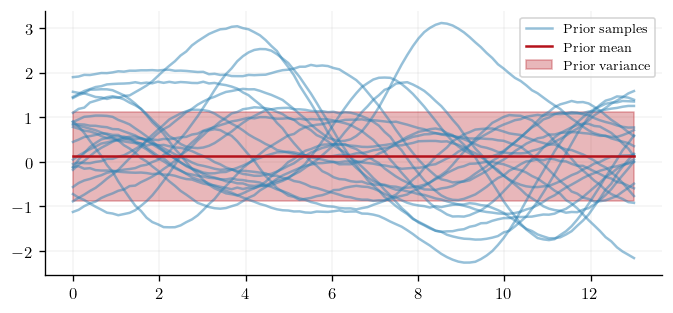

In [304]:
# Plot prior distribution

prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest[:, 0], samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest[:, 0], prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest[:, 0].flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)

In [305]:
# Constructing the posterior
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [306]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

Array(44.0322481, dtype=float64)

In [307]:
opt_posterior, history = gpx.fit(model=posterior, objective=negative_mll, train_data=D,optim=ox.adam(0.01), key=key, num_iters=100)

Running: 100%|██████████| 100/100 [00:02<00:00, 47.81it/s, Value=24.61]


In [308]:
# Custom posterior for p53
p53_posterior = p53_posterior(prior=opt_posterior.prior, likelihood=opt_posterior.likelihood)

In [309]:
p53_posterior.likelihood

Gaussian(num_datapoints=35, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.47789627, dtype=float32))

In [310]:
latent_dist = p53_posterior.latent_predict(xtest, p53_data)

In [311]:
latent_dist = p53_posterior.latent_predict(xtest, p53_data)
predictive_dist = p53_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

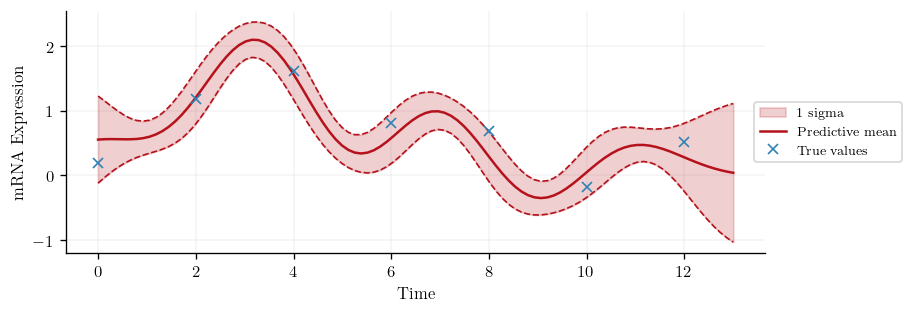

In [312]:
# Plot the GP
f = p53_data.f_observed.squeeze()
plot_gp(xtest, predictive_dist, y_scatter=f, stddev=1)

## Bar chart plotting

In [313]:
from gpjax.base import meta_leaves

post_leaves = meta_leaves(opt_posterior)

In [314]:
def process_data(data):
    from collections import defaultdict
    result = defaultdict(list)

    initial_lengthscale = jnp.array([2.5], dtype=jnp.float64)
    initial_sensitivities = jnp.array([1,1,1,1,1], dtype=jnp.float64)
    tolerance = jnp.array(1e-6, dtype=jnp.float64)

    for item in data:
        details, array = item
        name = details.get('name', 'noise').strip()
        array = jnp.array(array)
        if not (jnp.allclose(array, initial_lengthscale,rtol=0, atol=tolerance) or jnp.array_equal(array, initial_sensitivities)):
            result[name].append(array)
    print(result)
    
    final_result = {}
    for key, value in result.items():
        if len(value) > 1:
            stacked = jnp.stack(value, axis=0)
            averaged = jnp.mean(stacked, axis=0)
        else:
            averaged = value[0]

        final_result[key] = averaged

    return final_result

In [315]:
res = process_data(post_leaves)
res

defaultdict(<class 'list'>, {'noise': [Array(0.47789627, dtype=float32)], 'lengthscale': [Array(1.63664685, dtype=float64)], 'kxx_degradations': [Array([0.24331379, 0.26104308, 0.25080801, 0.59460816, 0.26244159],      dtype=float64), Array([0.23667199, 0.54498698, 0.3669528 , 0.57938681, 0.25477043],      dtype=float64)], 'kxx_sensitivities': [Array([0.78387866, 0.77329205, 0.74191605, 0.95023713, 0.77366564],      dtype=float64)], 'basal_rates': [Array([0.08896216, 0.03409267, 0.05548522, 0.0312709 , 0.08251393],      dtype=float64)]})


{'noise': Array(0.47789627, dtype=float32),
 'lengthscale': Array(1.63664685, dtype=float64),
 'kxx_degradations': Array([0.23999289, 0.40301503, 0.30888041, 0.58699749, 0.25860601],      dtype=float64),
 'kxx_sensitivities': Array([0.78387866, 0.77329205, 0.74191605, 0.95023713, 0.77366564],      dtype=float64),
 'basal_rates': Array([0.08896216, 0.03409267, 0.05548522, 0.0312709 , 0.08251393],      dtype=float64)}

In [316]:
def params_ground_truth():
        B_exact = jnp.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
        D_exact = jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
        S_exact = jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
        return B_exact, S_exact, D_exact

In [317]:
p53_data.gene_names

['DDB2', 'BIK', 'DR5', 'p21', 'SESN1']

In [318]:
def plot_comparison(output):
    B_exact, S_exact, D_exact = params_ground_truth()
    
    # Extract the relevant data from the output dictionary
    B_output = output['basal_rates']
    D_output = output['kxx_degradations']
    S_output = output['kxx_sensitivities']
    
    # Create the plots
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    # Plot basal_rates
    axes[0].bar(range(len(B_exact)), B_exact, width=0.4, label='B_exact', align='center')
    axes[0].bar([x + 0.4 for x in range(len(B_output))], B_output, width=0.4, label='basal_rates', align='center')
    axes[0].set_title('basal_rates vs B_exact')
    axes[0].legend()

    # Plot kxx_sensitivities
    axes[1].bar(range(len(S_exact)), S_exact, width=0.4, label='S_exact', align='center')
    axes[1].bar([x + 0.4 for x in range(len(S_output))], S_output, width=0.4, label='kxx_sensitivities', align='center')
    axes[1].set_title('kxx_sensitivities vs S_exact')
    axes[1].legend()

    # Plot kxx_degradations
    axes[2].bar(range(len(D_exact)), D_exact, width=0.4, label='D_exact', align='center')
    axes[2].bar([x + 0.4 for x in range(len(D_output))], D_output, width=0.4, label='kxx_degradations', align='center')
    axes[2].set_title('kxx_degradations vs D_exact')
    axes[2].legend()

    plt.show()

In [321]:
for idx, color in enumerate(cols):
    print(idx, color)

0 #2F83B4
1 #B5121B
2 #F77F00
3 #0B6E4F
4 #7A68A6
5 #C5BB36
6 #8c564b
7 #e377c2


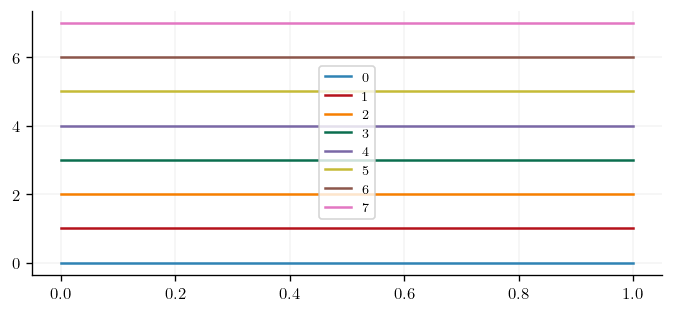

In [322]:
# visualise colors from colors variable

for idx, color in enumerate(cols):
    plt.plot([0, 1], [idx, idx], color=color, label=idx)
plt.legend()
plt.show()

In [288]:
def plot_comparison(output, gene_names):
    B_exact, S_exact, D_exact = params_ground_truth()
    
    
    # Extract the relevant data from the output dictionary
    B_output = output['basal_rates']
    D_output = output['kxx_degradations']
    S_output = output['kxx_sensitivities']
    
    # Create the plots
    fig, axes = plt.subplots(1, 3, figsize=(8.5, 3))

    # Set colours
    

    # Plot basal_rates
    x = jnp.arange(len(B_exact))
    axes[0].bar(x - 0.2, B_exact, width=0.4, label='B_exact')
    axes[0].bar(x + 0.2, B_output, width=0.4, label='basal_rates')
    axes[0].set_title('Basal rates')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(gene_names, rotation=45, ha="right")

    # Plot kxx_sensitivities
    axes[1].bar(x - 0.2, S_exact, width=0.4, label='S_exact')
    axes[1].bar(x + 0.2, S_output, width=0.4, label='kxx_sensitivities')
    axes[1].set_title('Sensitivities')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(gene_names, rotation=45, ha="right")

    # Plot kxx_degradations
    axes[2].bar(x - 0.2, D_exact, width=0.4, label='Measured')
    axes[2].bar(x + 0.2, D_output, width=0.4, label='Calculated')
    axes[2].set_title('Decay rates')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(gene_names, rotation=45, ha="right")

    # Single legend at the bottom
    handles, labels = axes[2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize='medium')
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

/var/folders/bl/8jtm6jln6xl3rgh70czj8_8r0000gn/T/ipykernel_14556/1039551413.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


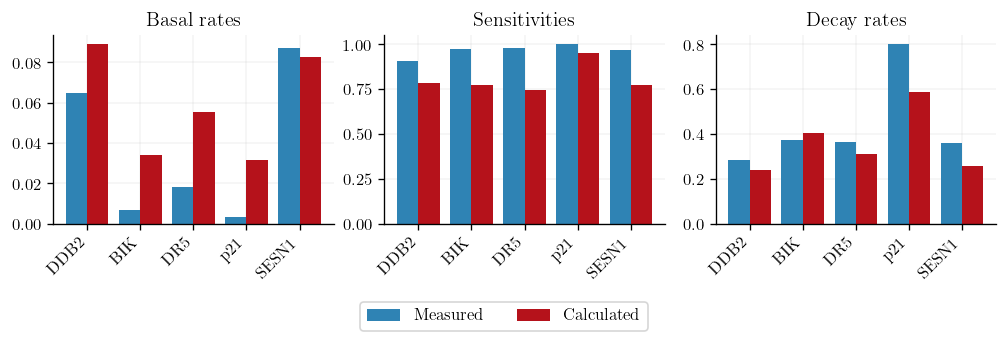

In [289]:
plot_comparison(res, p53_data.gene_names)